# **U.S airline sentiment**

data loading and importing nesessary library

In [24]:
import nltk
import numpy
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df=pd.read_csv('Tweets.csv.zip')

In [35]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,preprosessed_text,sentiment_score,hour
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 19:35:52+00:00,NaN,Eastern Time (US & Canada),@VirginAmerica @dhepburn say,0.0000,19
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 19:15:59+00:00,NaN,Pacific Time (US & Canada),@VirginAmerica plus add commercial experience ...,0.0000,19
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 19:15:48+00:00,Lets Play,Central Time (US & Canada),@VirginAmerica today mean need trip,0.0000,19
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 19:15:36+00:00,NaN,Pacific Time (US & Canada),@VirginAmerica aggressive blast obnoxious ente...,-0.5984,19
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 19:14:45+00:00,NaN,Pacific Time (US & Canada),@VirginAmerica big bad thing,-0.5829,19


In [41]:
df.isnull().sum()
df['tweet_created'] = pd.to_datetime(df['tweet_created'], utc=True)
df['day']=df['tweet_created'].dt.day
df['day'].value_counts()

,count
day,
23,3515
22,2392
24,2136
20,1512
21,1418
18,1416
19,1298
17,953


Data preprocessing

In [6]:
nlp=spacy.load('en_core_web_sm')
def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    return " ".join(filtered_tokens)
df['preprosessed_text']=df['text'].apply(lambda x:preprocess(x))

vectorization

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
X=tf.fit_transform(df['preprosessed_text'].values)

train test split

In [15]:
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

# Use the vectorized text and the airline_sentiment_confidence column as features
X_combined = hstack([X, df['airline_sentiment_confidence'].values.reshape(-1, 1)])
print(X_combined)
x_train,x_test,y_train,y_test=train_test_split(X_combined,df['airline_sentiment'],test_size=0.2,random_state=42)

<COOrdinate sparse matrix of dtype 'float64'
	with 145422 stored elements and shape (14640, 13205)>
  Coords	Values
  (0, 12534)	0.3688398092918796
  (0, 4305)	0.8405443428267354
  (0, 10351)	0.39679012440268907
  (1, 12534)	0.25998921947145487
  (1, 9316)	0.38990818981532055
  (1, 1901)	0.34496930985611085
  (1, 3658)	0.464389139527395
  (1, 5042)	0.30769515573333067
  (1, 11332)	0.5924861203084922
  (2, 12534)	0.3991400998695789
  (2, 11679)	0.41801581365853113
  (2, 7876)	0.5465042480990744
  (2, 8365)	0.3761449000533682
  (2, 11814)	0.4751821557897621
  (3, 12534)	0.17926549063448372
  (3, 1969)	0.3799184351040784
  (3, 2843)	0.36318417425172494
  (3, 8693)	0.3917915821312438
  (3, 4857)	0.302665854633163
  (3, 6002)	0.34644991339937137
  (3, 5100)	0.30956047163793576
  (3, 2150)	0.17203450856102082
  (3, 7469)	0.2629867184120525
  (3, 9846)	0.36318417425172494
  (4, 12534)	0.4144566567302045
  :	:
  (14615, 13204)	1.0
  (14616, 13204)	1.0
  (14617, 13204)	1.0
  (14618, 13204)	1.0


model training and evaluation

In [16]:

clf=MultinomialNB()
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

    negative       0.67      0.99      0.80      1889
     neutral       0.74      0.13      0.22       580
    positive       0.93      0.08      0.15       459

    accuracy                           0.68      2928
   macro avg       0.78      0.40      0.39      2928
weighted avg       0.73      0.68      0.59      2928

[[1878   11    0]
 [ 501   76    3]
 [ 405   16   38]]
0.680327868852459


In [18]:
from sklearn.linear_model import LogisticRegression
cl=LogisticRegression()
cl.fit(x_train,y_train)
y_pred=cl.predict(x_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

    negative       0.82      0.92      0.87      1889
     neutral       0.60      0.47      0.53       580
    positive       0.80      0.59      0.68       459

    accuracy                           0.78      2928
   macro avg       0.74      0.66      0.69      2928
weighted avg       0.77      0.78      0.77      2928

[[1745  112   32]
 [ 271  272   37]
 [ 117   71  271]]
0.7814207650273224


sentiment plot

In [26]:

nltk.download('vader_lexicon')
sia=SentimentIntensityAnalyzer()
df['sentiment_score']=df['text'].apply(lambda x:sia.polarity_scores(x)['compound'])


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


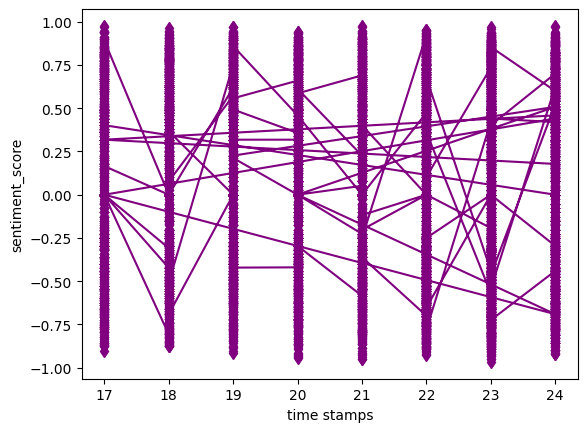

In [42]:
plt.plot(df['day'],df['sentiment_score'],marker='d',color='purple')
plt.xlabel('time stamps')
plt.ylabel('sentiment_score')
plt.show()